In [1]:
import os

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
def calculate_cagr(df, start:int, end:int):
    use_df = df.copy()
    value_dict = {}

    for year in range(start,end):
        tmp_df = use_df.loc[str(year)]
        cagr = (tmp_df + 1).cumprod().iloc[-1]
        # key는 년도, 값은 cagr로 딕셔너리에 담는다
        value_dict[year] = cagr

    return value_dict

In [3]:
price_df = pd.read_csv("mongo_price.csv", index_col=0,
                       parse_dates=True)
mktcap_df = pd.read_csv("mongo_mkt.csv", index_col=0,
                        parse_dates=True)

In [4]:
# 중간에 데이터가 비는 코인을 찾자
wrong_cols = []
for col in mktcap_df.columns:
    try:
        if len(mktcap_df.loc[mktcap_df[col].dropna().index[0]:mktcap_df[col].dropna().index[-1]]) != len(mktcap_df[col].dropna()):
            wrong_cols.append(col)
    except:
        pass

len(wrong_cols)

1069

In [5]:
price_df.drop(wrong_cols, axis=1, inplace=True)
mktcap_df.drop(wrong_cols, axis=1, inplace=True)

In [6]:
daily_return = price_df.pct_change()
weekly_return = price_df.pct_change(7)

problematic_cols = []
for col in daily_return.columns:
    if daily_return[col].max() > 10000:
        problematic_cols.append(col)

daily_return = daily_return.drop(problematic_cols, axis=1)
weekly_return = weekly_return.drop(problematic_cols, axis=1)
mktcap_df = mktcap_df.drop(problematic_cols, axis=1)

In [7]:
screen_by_mktcap = mktcap_df.applymap(lambda x: 1 if x>1_000_000 else np.nan)

In [8]:
problematic_idxs = []

count_before = 0
tmp = screen_by_mktcap.count(axis=1)
for idx in tqdm(screen_by_mktcap.index):
    target_val = tmp.loc[idx]
    if count_before != 0:
        if (target_val - count_before) / count_before < -0.5:
            #print(idx)
            problematic_idxs.append(idx)
    count_before = target_val

100%|██████████| 3652/3652 [00:00<00:00, 30424.48it/s]


In [9]:
daily_return = daily_return.drop(problematic_idxs, axis=0)
weekly_return = weekly_return.drop(problematic_idxs, axis=0)
pf_mktcap_weighted = mktcap_df.drop(problematic_idxs, axis=0)
mktcap_df = mktcap_df.drop(problematic_idxs, axis=0)
screen_by_mktcap = screen_by_mktcap.drop(problematic_idxs, axis=0)

In [10]:
mktcap_df_screened = mktcap_df * screen_by_mktcap

In [11]:
mktcap_df_screened.count(axis=1)

2013-01-01       0
2013-01-02       0
2013-01-03       0
2013-01-04       0
2013-01-05       0
              ... 
2022-12-27    1182
2022-12-28    1185
2022-12-29    1176
2022-12-30    1174
2022-12-31    1173
Length: 3652, dtype: int64

In [12]:
mktcap_weight = mktcap_df_screened.apply(lambda x: x/np.nansum(x), axis=1)
tmp = mktcap_df_screened.copy()
tmp[tmp.isna()==False] = 1
equal_weight = tmp.apply(lambda x: x/x.count(), axis=1)

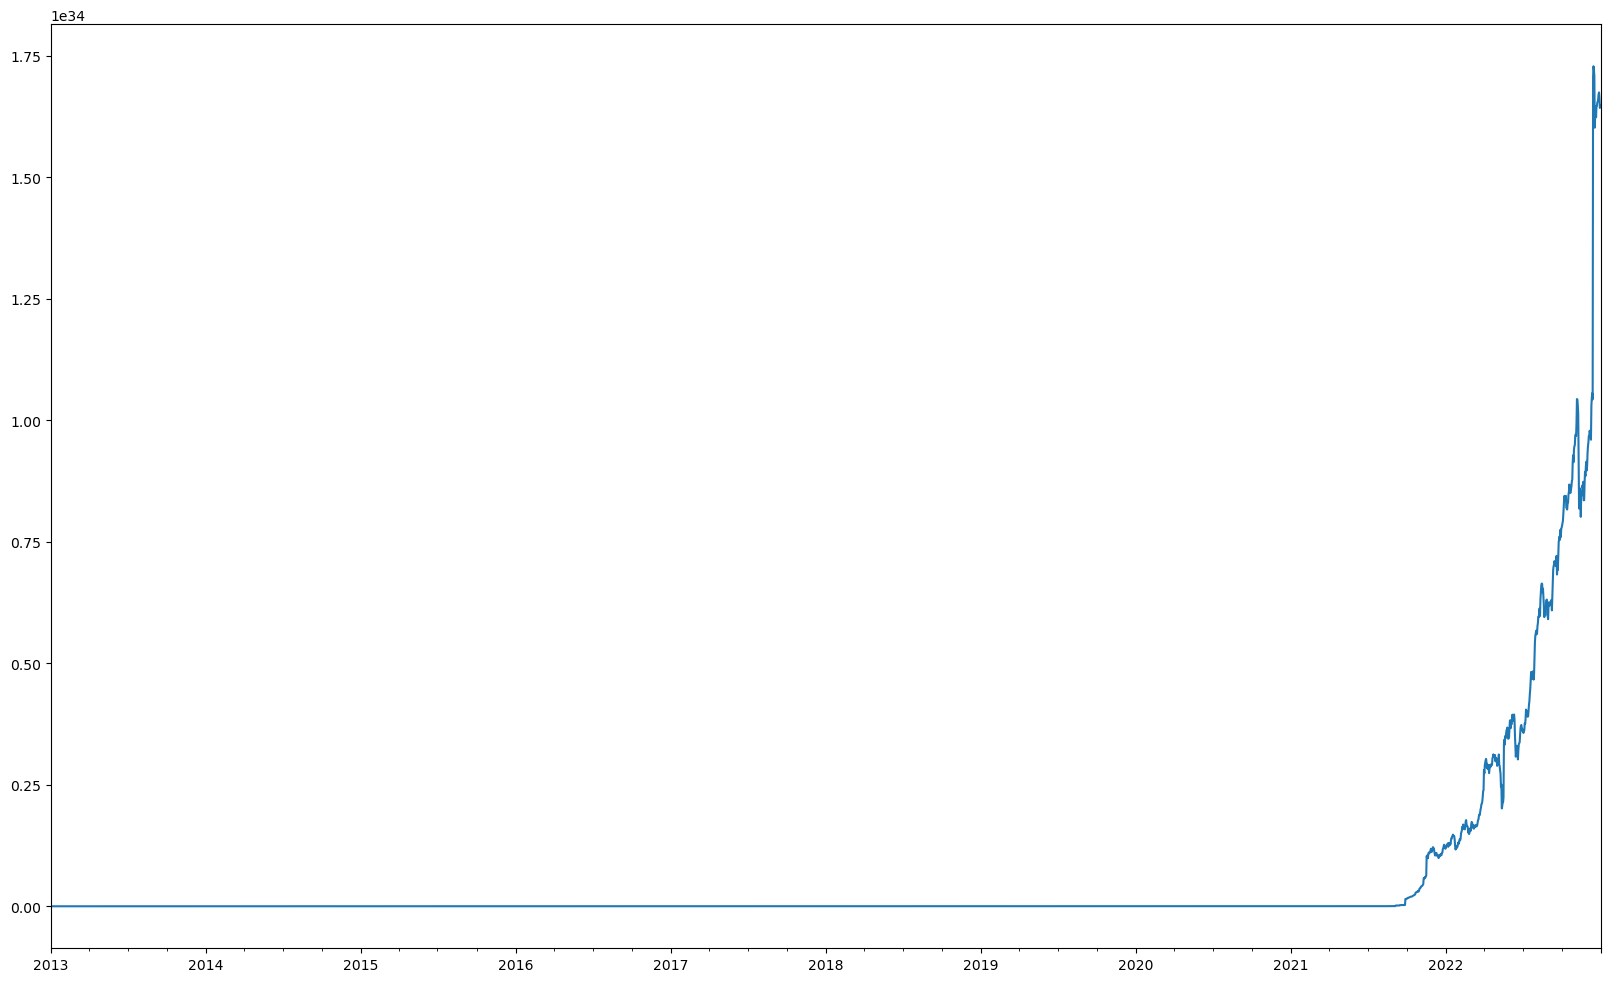

In [13]:
# Equal Weight 포트폴리오의 리턴
pf_return = (daily_return*equal_weight).sum(axis=1)

plt.figure(figsize=(20,12))
(pf_return+1).cumprod().loc[:].plot();

In [14]:
pd.Series(calculate_cagr(pf_return, 2013,2023))

2013    2.219572e+01
2014    2.384094e+00
2015    3.837110e+00
2016    1.726558e+01
2017    2.732404e+03
2018    8.304891e+00
2019    6.557621e+07
2020    1.665768e+10
2021    1.382527e+07
2022    1.371784e+01
dtype: float64

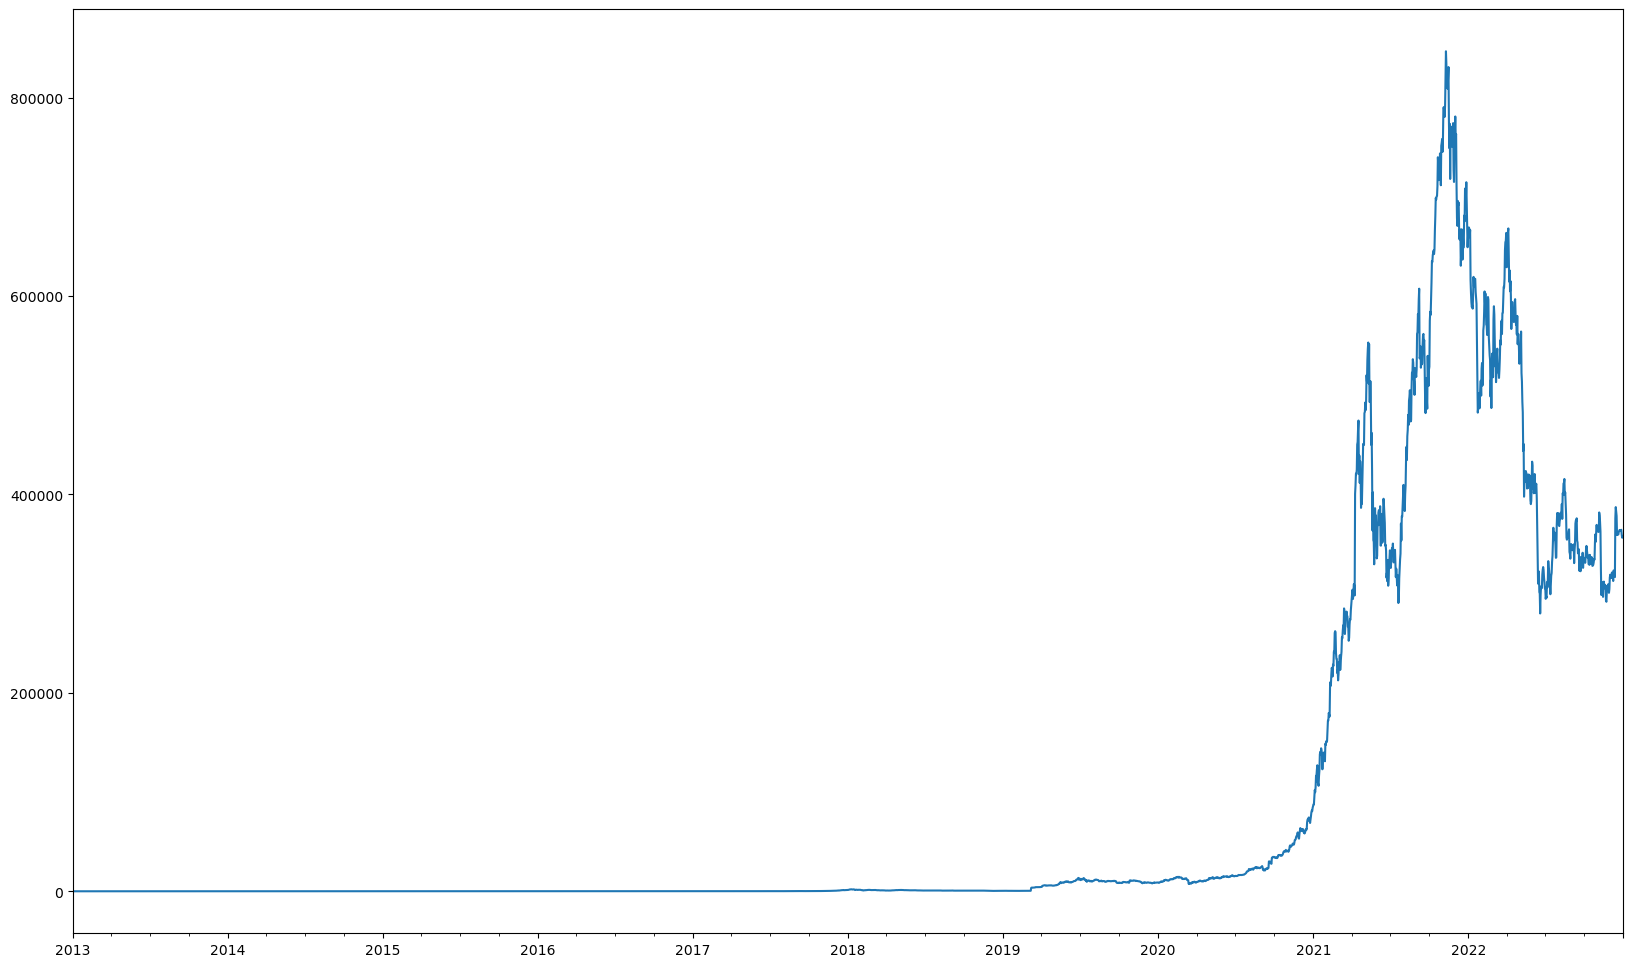

In [16]:
# 시총 가중 평균 포트폴리오의 리턴 
pf_return = (daily_return*mktcap_weight).sum(axis=1)

plt.figure(figsize=(20,12))
(pf_return+1).cumprod().loc[:].plot();

In [17]:
pd.Series(calculate_cagr(pf_return, 2013,2023))

2013     6.296055
2014     0.573296
2015     1.352730
2016     2.932576
2017    89.288654
2018     0.370371
2019    18.460631
2020     9.842114
2021     7.669899
2022     0.541002
dtype: float64

In [18]:
pf_self_daily_return = (pf_return+1).cumprod().pct_change(1)
pf_self_weekly_return = (pf_return+1).cumprod().pct_change(7)

In [19]:
q1_pf_return = pf_self_weekly_return[pf_self_weekly_return >= pf_self_weekly_return.quantile(0.66)]

q2_pf_return = pf_self_weekly_return[pf_self_weekly_return < pf_self_weekly_return.quantile(0.66)]
q2_pf_return = q2_pf_return[q2_pf_return >= pf_self_weekly_return.quantile(0.33)]

q3_pf_return = pf_self_weekly_return[pf_self_weekly_return < pf_self_weekly_return.quantile(0.33)]

In [20]:
yesterday_q1 = []
yesterday_q2 = []
yesterday_q3 = []

q1_index = q1_pf_return.index
q2_index = q2_pf_return.index
q3_index = q3_pf_return.index

tmp_index = pf_self_daily_return.index
for i in range(len(tmp_index)-1):
    current_index = tmp_index[i]
    if current_index in q1_index:
        yesterday_q1.append(pf_self_daily_return.loc[current_index])
    elif current_index in q2_index:
        yesterday_q2.append(pf_self_daily_return.loc[current_index])
    elif current_index in q3_index:
        yesterday_q3.append(pf_self_daily_return.loc[current_index])

In [23]:
#plt.figure(figsize=(24,12))
#screen_by_mktcap.count(axis=1).plot()

3Q Regression

In [22]:
q1_bound = daily_return.apply(lambda x: np.nanquantile(x, 0.333), axis=1)
q2_bound = daily_return.apply(lambda x: np.nanquantile(x, 0.666), axis=1)
# q2가 더 큰 수임

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [24]:
q1_mask = daily_return.apply(lambda x: x < q1_bound, axis=0)
q2_mask = (daily_return.apply(lambda x: x >= q1_bound, axis=0)) & \
          (daily_return.apply(lambda x: x < q2_bound, axis=0))
q3_mask = daily_return.apply(lambda x: x >= q2_bound, axis=0)

In [71]:
# 횡단면 Momentum의 분위수로 screening 한 것의 weight를 구함
q1_weight = (q1_mask * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)
q2_weight = (q2_mask * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)
q3_weight = (q3_mask * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)

In [72]:
# weight된 수익률을 구함
q1 = ((q1_weight * daily_return.shift(-1)).sum(axis=1) + 1) \
                          .cumprod() \
                          #.plot(figsize=(20,12));

In [73]:
q2 = ((q2_weight * daily_return.shift(-1)).sum(axis=1) + 1).cumprod()\
                                    #.plot(figsize=(20,12));

In [74]:
q3 = ((q3_weight * daily_return.shift(-1)).sum(axis=1) + 1).cumprod()\
    #.plot(figsize=(20,12));

In [82]:
Q = pd.DataFrame([q1,q2,q3], index=["Q1","Q2","Q3"]).T
Q

,Q1,Q2,Q3
2013-01-01,1.000000,1.000000,1.000000
2013-01-02,1.000000,1.000000,1.000000
2013-01-03,1.000000,1.000000,1.000000
2013-01-04,1.000000,1.000000,1.000000
2013-01-05,1.000000,1.000000,1.000000
...,...,...,...
2022-12-27,0.011753,9.969583,141407.886712
2022-12-28,0.011653,9.969583,138403.454375
2022-12-29,0.011682,9.970669,138203.691685
2022-12-30,0.011683,9.970669,138003.330125


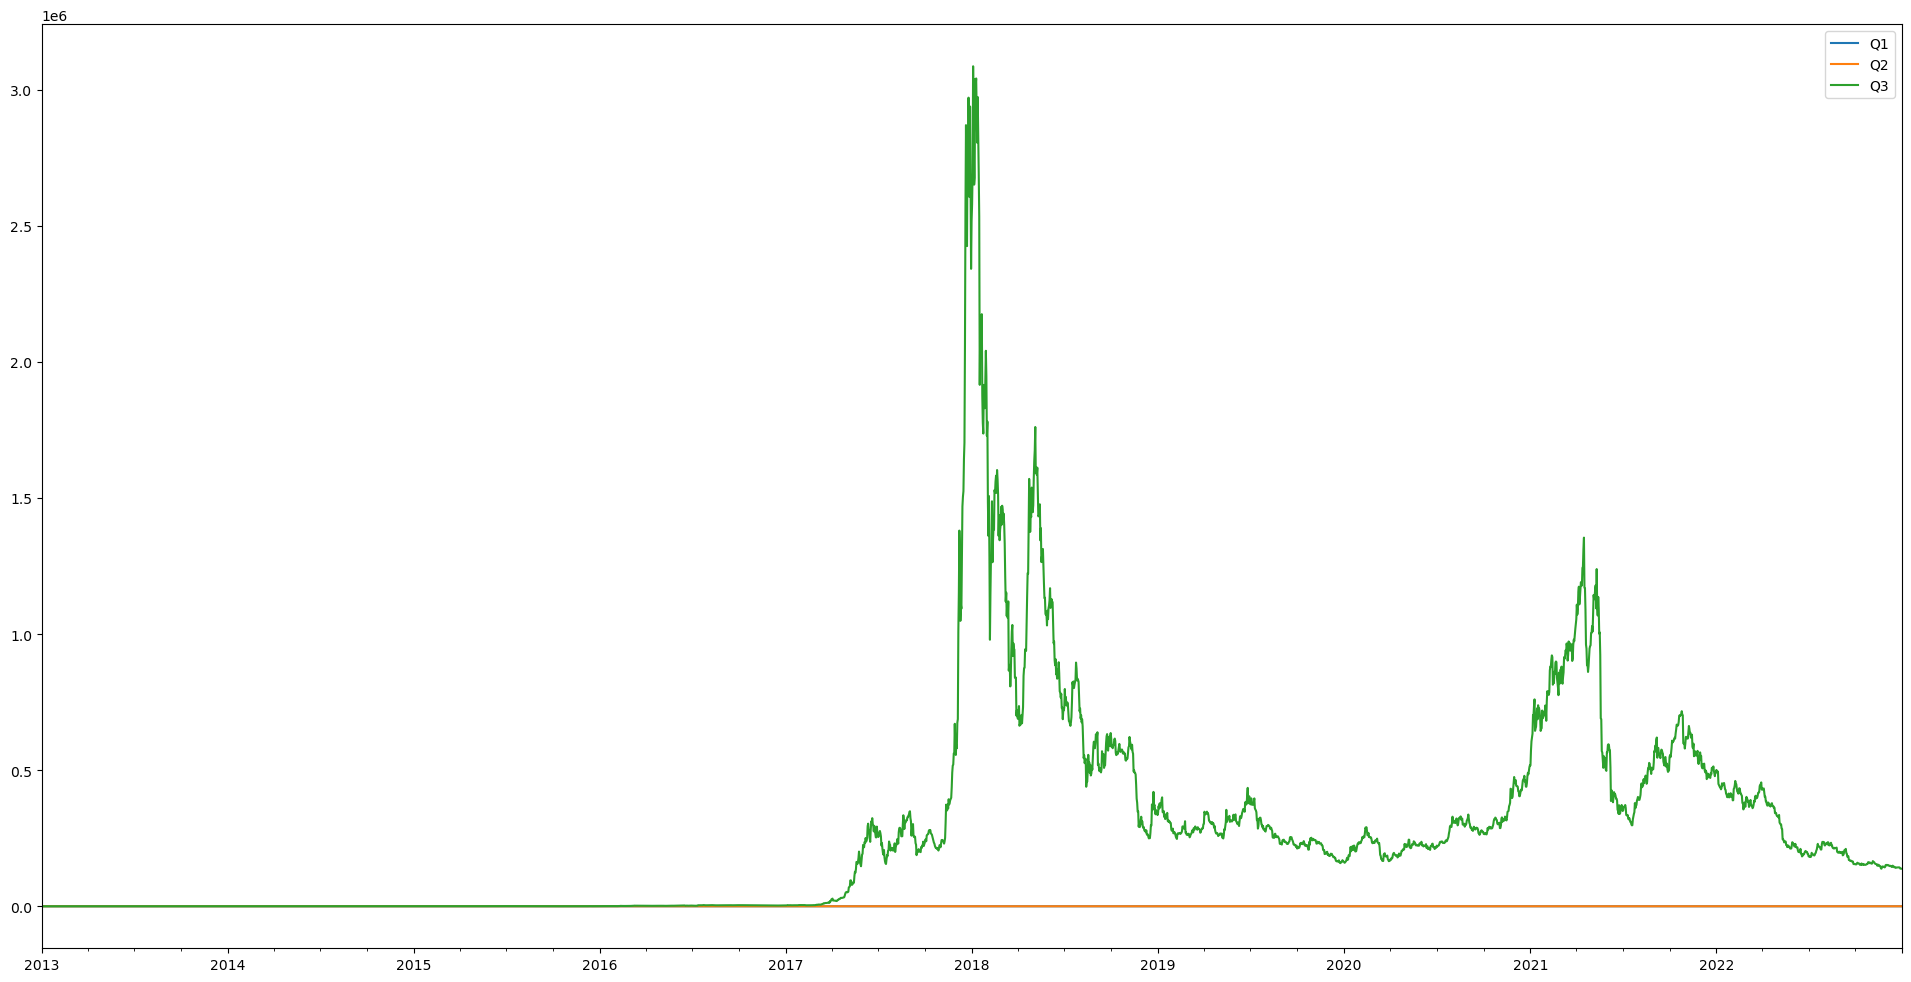

In [85]:
Q.plot(figsize=(24,12));

Size Effect

In [35]:
# calculate the total market cap of all stocks
total_market_cap = mktcap_df_screened.sum(axis=1)

# calculate the size quartiles
q1_bound = mktcap_df_screened.apply(lambda x: np.nanquantile(x, 0.2), axis=1)
q2_bound = mktcap_df_screened.apply(lambda x: np.nanquantile(x, 0.4), axis=1)
q3_bound = mktcap_df_screened.apply(lambda x: np.nanquantile(x, 0.6), axis=1)
q4_bound = mktcap_df_screened.apply(lambda x: np.nanquantile(x, 0.8), axis=1)

one = mktcap_df_screened.apply(lambda x: x < q1_bound, axis=0)
two = (mktcap_df_screened.apply(lambda x: x >= q1_bound, axis=0)) & \
          (mktcap_df_screened.apply(lambda x: x < q2_bound, axis=0))
three = (mktcap_df_screened.apply(lambda x: x >= q2_bound, axis=0)) & \
          (mktcap_df_screened.apply(lambda x: x < q3_bound, axis=0))
four = (mktcap_df_screened.apply(lambda x: x >= q3_bound, axis=0)) & \
          (mktcap_df_screened.apply(lambda x: x < q4_bound, axis=0))
five = mktcap_df_screened.apply(lambda x: x >= q4_bound, axis=0)

# Weight를 구함  
one_weight = (one * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)
two_weight = (two * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)
three_weight = (three * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)
four_weight = (four * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)
five_weight = (five * mktcap_df_screened) \
            .apply(lambda x: x / np.nansum(x), axis=1)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [40]:
one = (((one_weight * daily_return)).sum(axis=1) + 1).cumprod()#.plot(figsize=(24,12));

In [41]:
two = (((two_weight * daily_return)).sum(axis=1) + 1).cumprod()#.plot(figsize=(24,12));

In [42]:
three = (((three_weight * daily_return)).sum(axis=1) + 1).cumprod()#.plot(figsize=(24,12));

In [43]:
four = (((four_weight * daily_return)).sum(axis=1) + 1).cumprod()#.plot(figsize=(24,12));

In [47]:
five = (((five_weight * daily_return)).sum(axis=1) + 1).cumprod()#.plot(figsize=(24,12));

In [55]:
pd.DataFrame([one,two,three,four,five], index=["Small","Two","Three","Four","BIG"]).T

,Small,Two,Three,Four,BIG
2013-01-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
2013-01-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
2013-01-03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
2013-01-04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
2013-01-05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
...,...,...,...,...,...
2022-12-27,3.070988e+28,5.043951e+31,1.635851e+26,7.818251e+21,62118.185879
2022-12-28,3.051664e+28,4.977205e+31,1.654248e+26,7.732010e+21,61331.300725
2022-12-29,3.026804e+28,4.954015e+31,1.635624e+26,7.553098e+21,60768.483979
2022-12-30,3.036984e+28,4.972086e+31,1.631363e+26,7.556136e+21,60921.546029


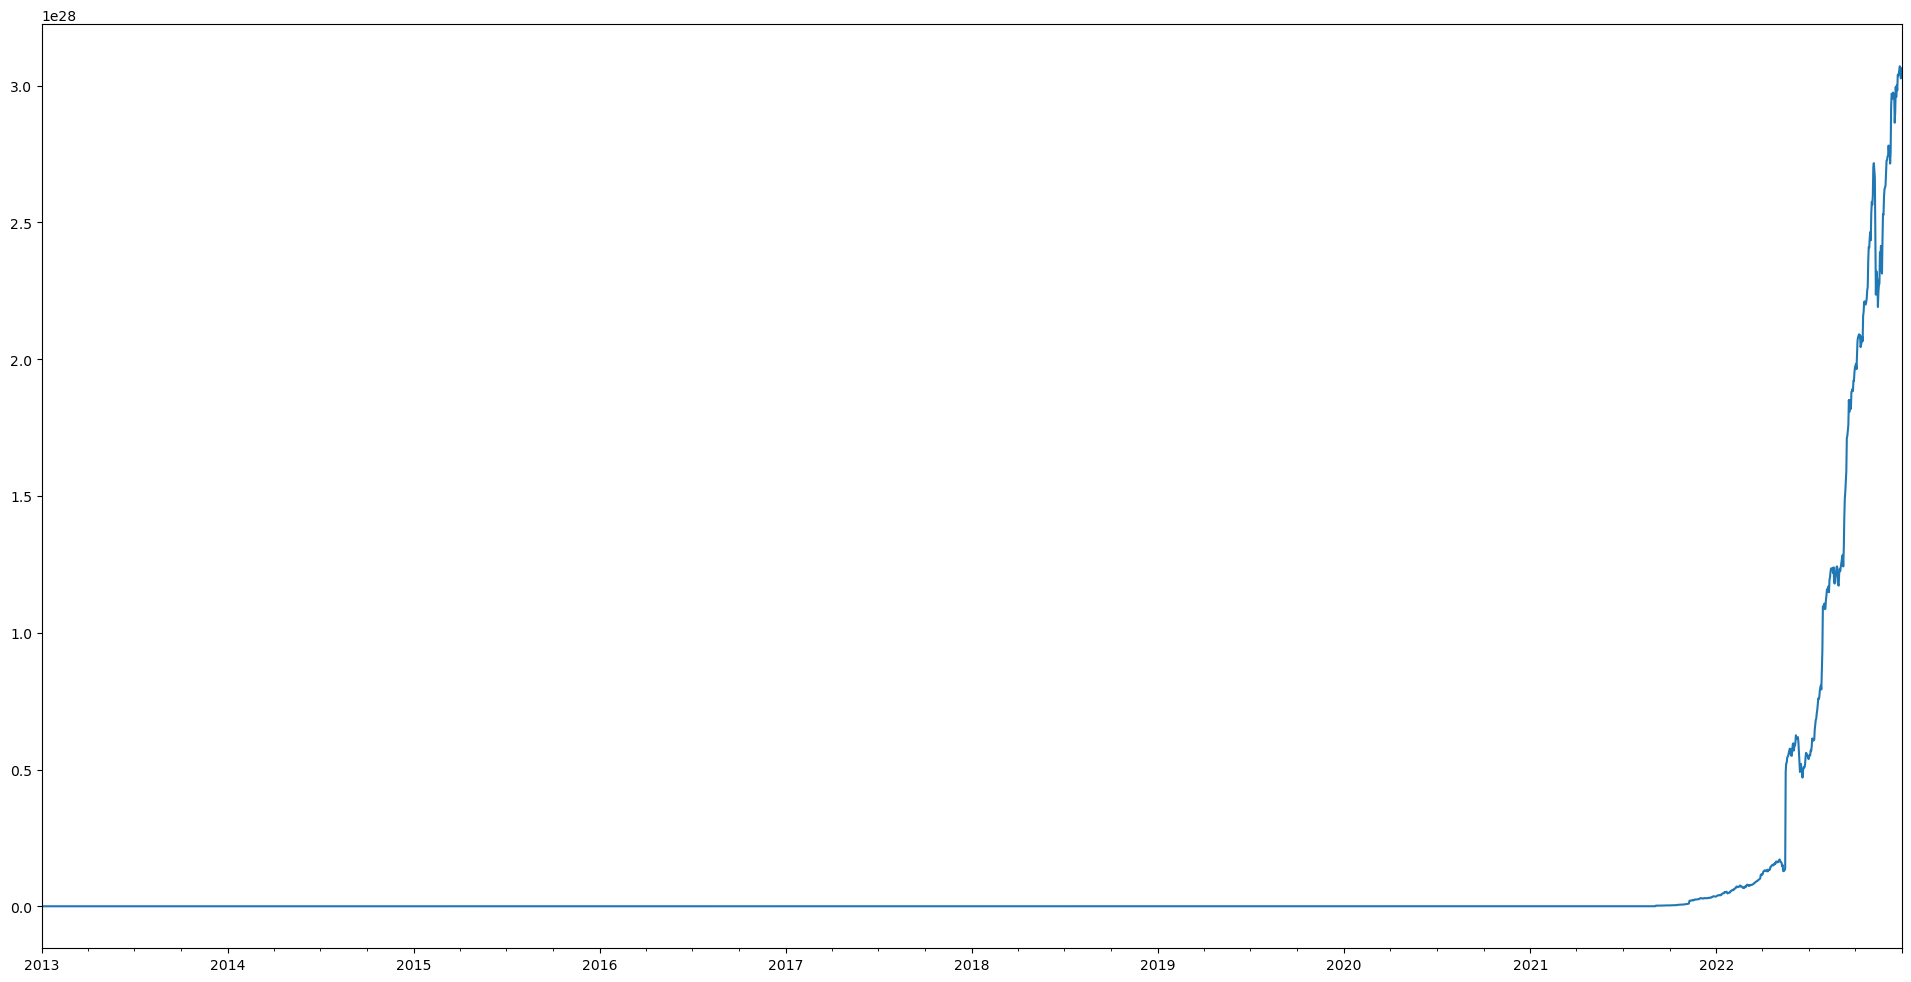

In [57]:
one.plot(figsize=(24,12));

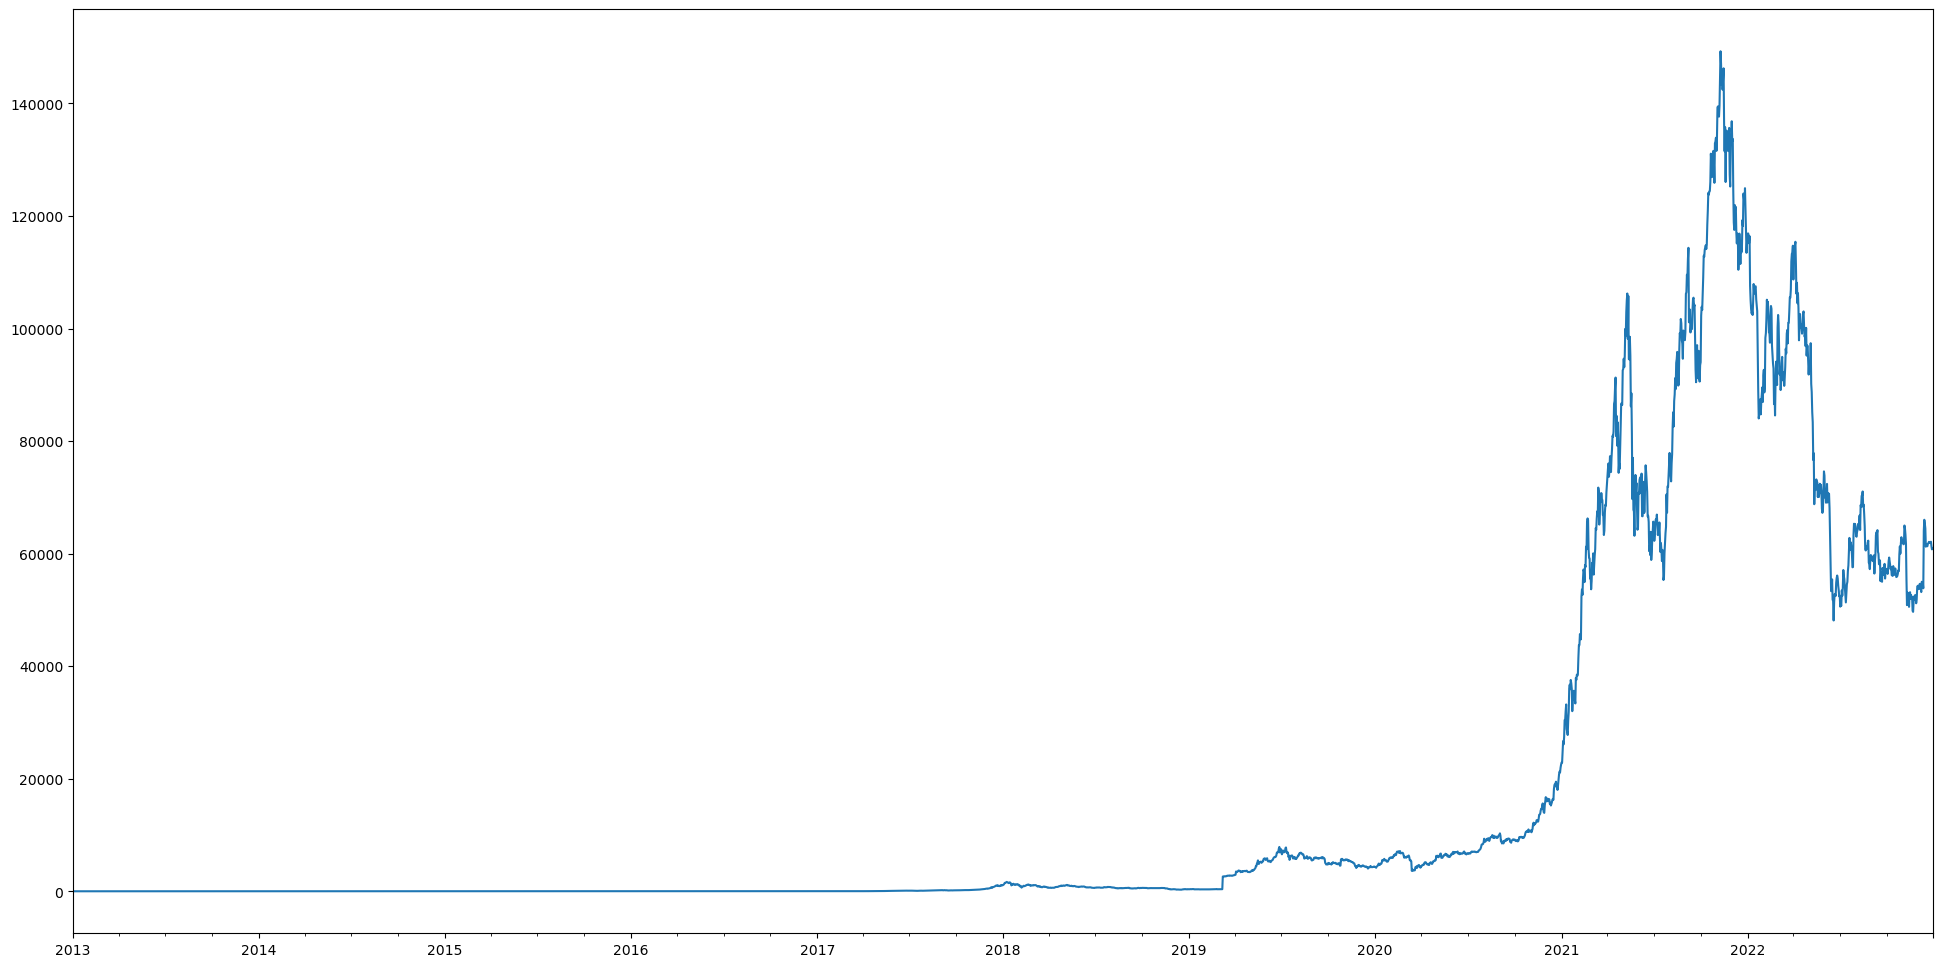

In [59]:
five.plot(figsize=(24,12));